<h1><center>GANdido Portinari - Neural Style Transfer using CycleGANs</center></h1>



# Table of Contents

* [1. Introduction](#1.-Introduction)
* [2. Methodology](#2.-Methodology)
* [3. Development](#3.-Development)
* [4. Results](#4.-Results)
* [5. References](#5.-References)


# 1. Introduction

Our work primarily focuses on the use and implementation of GANs, specifically CycleGAN. GANs are an architecture for training generative models, such as deep convolutional neural networks, and have various applications like generating images, videos, text, and others. The application of GANs in this work involved generating images based on the works of Candido Portinari, who was an important Brazilian visual artist of the modernist phase with worldwide recognition. The GAN architecture is composed of a generator and a discriminator model. The generator is responsible for creating new outputs that can be real images—in this work, they were images. And the discriminator model is responsible for classifying the images from the generator, using a database of real images.

In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.2 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
#from losses import discriminator_loss, generator_loss, calc_cycle_loss, identity_loss
#from generator import Generator
#from discriminator import Discriminator
#from data_generator import load_dataset
#from cycleGAN import CycleGan
import matplotlib.pyplot as plt
import re
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

gpu = len(tf.config.list_physical_devices('GPU'))>0

if gpu:
    print("GPU is", "available")
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("NOT AVAILABLE")

AUTOTUNE = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


GPU is available


<h2>2. Methodology</h2>

<p>&emsp;The data used in this project were images obtained from a simple request script from Portinari's own website, which can be found in the references. About five thousand works were used. For data processing, it was necessary to standardize the image sizes for input into the network to 256x256, and after that, the CycleGAN was trained.</p>


## Data Input

In [4]:
# load gandido.zip from local machine(your PC).. upload gandido.zip file
from google.colab import files
uploaded = files.upload()


Saving gandido.zip to gandido.zip


In [5]:
# load photo.zip from local machine(your PC)... upload photo.zip file
from google.colab import files
uploaded = files.upload()

Saving photo.zip to photo.zip


In [6]:
# unzip both of the zip files into google colab
!unzip gandido.zip
!unzip photo.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo/67ad9f90eb.jpeg   
  inflating: photo/67ae13d8fd.jpeg   
  inflating: photo/67b03b9ae6.jpeg   
  inflating: photo/67b2023cdc.jpeg   
  inflating: photo/67b303bc1f.jpeg   
  inflating: photo/67bf2caa0d.jpeg   
  inflating: photo/67cb59fe1b.jpeg   
  inflating: photo/67d30c5976.jpeg   
  inflating: photo/67e82318a8.jpeg   
  inflating: photo/67fa0b1fff.jpeg   
  inflating: photo/67ffae436a.jpeg   
  inflating: photo/680e403ee6.jpeg   
  inflating: photo/68161f940a.jpeg   
  inflating: photo/681747f03e.jpeg   
  inflating: photo/681949c029.jpeg   
  inflating: photo/681df42505.jpeg   
  inflating: photo/682e0844c2.jpeg   
  inflating: photo/6836334767.jpeg   
  inflating: photo/683ff91f55.jpeg   
  inflating: photo/684690671a.jpeg   
  inflating: photo/684be8790c.jpeg   
  inflating: photo/685174f022.jpeg   
  inflating: photo/6852f4cb2d.jpeg   
  inflating: photo/685923a424.jpeg   
  inflating: photo/68730b2016.jpeg   

In [30]:
# Use TensorFlow's glob function to collect all JPEG files in the 'gandido' folder
GANDIDO_FILENAMES = tf.io.gfile.glob('gandido/*.jpeg')

# Print the number of files found in the 'gandido' folder
print('Gandido Files:', len(GANDIDO_FILENAMES))

# Use TensorFlow's glob function to collect all JPEG files in the 'photo' folder
PHOTO_FILENAMES = tf.io.gfile.glob('photo/*.jpeg')

# Print the number of files found in the 'photo' folder
print('Photo Files:', len(PHOTO_FILENAMES))


Gandido Files: 4580
Photo Files: 7947


In [31]:
# Set the target size for the images to 256x256 pixels
IMAGE_SIZE = [256, 256]

# Function to decode and preprocess the image
def decode_image(image):
    # Decode the JPEG image and set its channels to 3 (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    # Normalize the pixel values to the range [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    # Resize the image to the target size using nearest neighbor interpolation
    image = tf.image.resize(image, IMAGE_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Reshape the image tensor to the target shape
    image = tf.reshape(image, [*IMAGE_SIZE, 3])

    return image

# Function to read and process an image file
def process(example):
    # Read the image file
    img = tf.io.read_file(example)

    # Decode and preprocess the image using the decode_image function
    image = decode_image(img)

    return image


In [9]:
# Function to load a dataset from a given image path
def load_dataset(img_path, labeled=True, ordered=False):
    # Create a dataset of file paths matching the provided image path
    dataset = tf.data.Dataset.list_files(img_path)

    # Map the processing function to each file path in the dataset
    dataset = dataset.map(lambda x: process(x))

    return dataset


In [10]:
candido_datagen = tf.data.Dataset.list_files("./gandido/*.jpeg")
photo_datagen = tf.data.Dataset.list_files("./photo/*.jpeg")


candido_ds = candido_datagen.map(lambda x: process(x)).batch(4)

photo_ds = photo_datagen.map(lambda x: process(x)).batch(4)

In [11]:
example_candido = next(iter(candido_ds))
example_photo = next(iter(photo_ds))

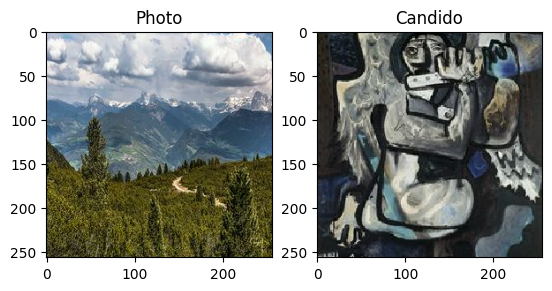

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0]* 0.5 + 0.5)

plt.subplot(122)
plt.title('Candido')
plt.imshow(example_candido[0]* 0.5 + 0.5)

## Implementation of Downsample and Upsample


<b>2.1 Downsample Layer</b><br/>
&emsp;The Downsample layer is required for standardizing the sizes of the images. The function takes parameters such as filters, size, and instancenorm. The 'filters' parameter specifies how many filters will be used, 'size' specifies the shape of these filters, and 'instancenorm' is a flag indicating whether a normalized instance will be used or not.
</p>


In [13]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

<b>2.1 Upsample Layer</b><br/>
&emsp;The Upsample layer is used to enlarge the images to ensure better sampling, unlike the downsample layer. It also uses the function ```Conv2DTranspose()```. The function takes parameters such as filters, size, and a flag that indicates whether Dropout will be used or not. The 'filters' parameter specifies how many filters will be used, and 'size' specifies the shape of these filters.
</p>


In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## Implementation of the Generator


<p>Below, we have the implementation of the Generator function, which will be used as a model for creating objects responsible for generating images in the style of Portinari and for adding a more realistic view to some of Portinari's works or sketches, as we will see later. It utilizes multiple layers of upsample and downsample, which are concatenated. The function takes an image as input and processes it using the previously mentioned downsample function.</p>


In [15]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Implementation of the Discriminator
The Discriminator function will be responsible for creating the objects that will serve to identify whether an image belongs to a certain distribution or not. In our CycleGAN model, for example, we will have two discriminators. One of these objects will be responsible for determining whether an image resembles the works of Portinari or not. The other will serve to indicate whether an image is real or a work of art. The discriminator receives data from the generator, which can be real or fake (generated) images, as well as from a database of real images (from the domain) for classification.


In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

## CycleGAN
In this section, we have the implementation of our CycleGAN model using the `keras.Model` function, serving as a *blueprint*. Different projects implemented based on this network can be seen [at this link](https://junyanz.github.io/CycleGAN/). For a deeper theoretical understanding, the [paper on the network's implementation on arxiv](https://arxiv.org/pdf/1703.10593.pdf) can be read.


In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        candido_generator,
        photo_generator,
        candido_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = candido_generator
        self.p_gen = photo_generator
        self.m_disc = candido_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_candido, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to candido back to photo
            fake_candido = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_candido, training=True)

            # candido to photo back to candido
            fake_photo = self.p_gen(real_candido, training=True)
            cycled_candido = self.m_gen(fake_photo, training=True)

            # generating itself
            same_candido = self.m_gen(real_candido, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_candido = self.m_disc(real_candido, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_candido = self.m_disc(fake_candido, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            candido_gen_loss = self.gen_loss_fn(disc_fake_candido)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_candido, cycled_candido, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_candido_gen_loss = candido_gen_loss + total_cycle_loss + self.identity_loss_fn(real_candido, same_candido, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            candido_disc_loss = self.disc_loss_fn(disc_real_candido, disc_fake_candido)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        candido_generator_gradients = tape.gradient(total_candido_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        candido_discriminator_gradients = tape.gradient(candido_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(candido_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(candido_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "candido_gen_loss": total_candido_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "candido_disc_loss": candido_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Losses
* Here we will list the metrics that will be used for the execution of our code.


###### Discriminator Loss
The discriminator loss function compares a real image to an array of ones of the same shape. The function also compares generated (fake) images to an array of zeros, also of the same shape. As output, the network returns the average between these two generated losses.


In [18]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

###### Generator Loss
The generator tries to "fool" the discriminator by attempting to pass off a generated image as real. A perfect generator will output only ones from the discriminator, indicating that the image passed as real. It then compares the generated image with an array of ones of the same shape to calculate the loss.


In [19]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

###### Cycle Loss
Since we want our original photo and the photo transformed twice to be similar to each other, we calculate the cycle consistency by finding the average difference between the pixels of these two provided images.


In [20]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

###### Identity Loss
The identity loss function compares the image with its generator output. Given an image as an example, we want to generate the same image from the generator. This loss function compares the given input— in this case, a photo— with the output from the generator for that same photo.


In [21]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## Model Definition


In [22]:
gandido_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

gandido_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
gandido_generator = Generator()
photo_generator = Generator()

In [24]:
gandido_discriminator = Discriminator()
photo_discriminator = Discriminator()

In [25]:
cycle_gan_model = CycleGan(
    gandido_generator, photo_generator, gandido_discriminator, photo_discriminator
)

In [26]:
cycle_gan_model.compile(
    gandido_generator_optimizer,
    photo_generator_optimizer,
    gandido_discriminator_optimizer,
    photo_discriminator_optimizer,
    generator_loss,
    discriminator_loss,
    calc_cycle_loss,
    identity_loss
)

## Training and Results
The training took around 5 hours in google colab using V100GPU with High Ram using Paid Google Colab+ subscription, the codes after training show the resulting images from the model.


In [27]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((candido_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
1145/1145 [==============================] - 418s 314ms/step - candido_gen_loss: 4.1437 - photo_gen_loss: 4.3422 - candido_disc_loss: 0.5120 - photo_disc_loss: 0.5179
Epoch 2/25
1145/1145 [==============================] - 360s 314ms/step - candido_gen_loss: 3.7648 - photo_gen_loss: 3.8329 - candido_disc_loss: 0.4699 - photo_disc_loss: 0.5277
Epoch 3/25
1145/1145 [==============================] - 360s 314ms/step - candido_gen_loss: 4.0835 - photo_gen_loss: 3.9051 - candido_disc_loss: 0.4220 - photo_disc_loss: 0.5246
Epoch 4/25
1145/1145 [==============================] - 360s 314ms/step - candido_gen_loss: 4.1360 - photo_gen_loss: 3.8851 - candido_disc_loss: 0.4023 - photo_disc_loss: 0.5216
Epoch 5/25
1145/1145 [==============================] - 360s 314ms/step - candido_gen_loss: 4.1792 - photo_gen_loss: 3.7704 - candido_disc_loss: 0.3837 - photo_disc_loss: 0.5347
Epoch 6/25
1145/1145 [==============================] - 360s 314ms/step - candido_gen_loss: 4.0758 - photo_gen

In [28]:
j = 0

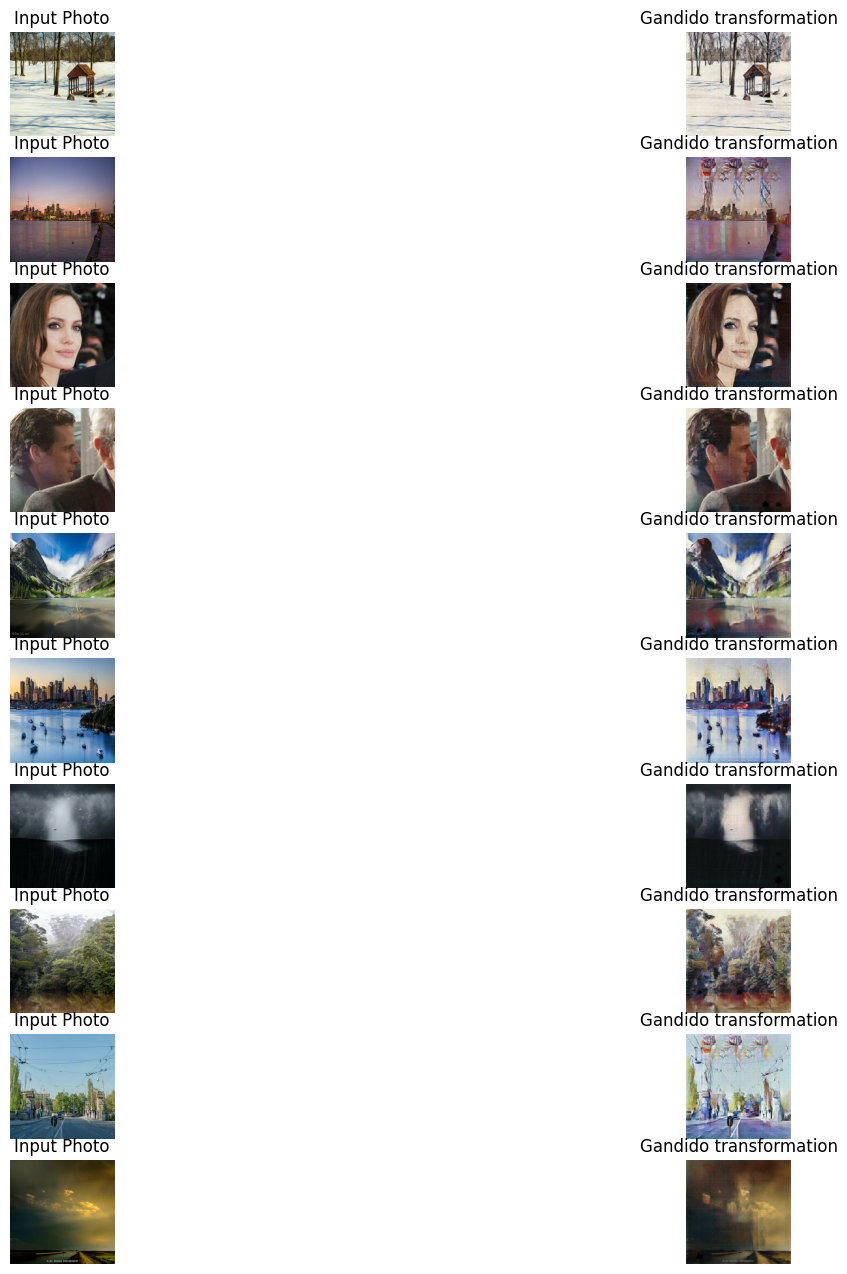

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Display the training results:

_, ax = plt.subplots(10, 2, figsize=(16, 16))
for i, img in enumerate(photo_ds.take(10)):
    prediction = gandido_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Gandido transformation")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.show()


In [52]:
gandido_generator.save("gandido_generator.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("gandido_generator_checkpoint.keras", save_best_only=True)

# Then pass `checkpoint_cb` to the `callbacks` argument of `model.fit()`


In [40]:
#from google.colab import drive
#drive.mount('/content/drive')
#gandido_generator.save('/content/drive/My Drive/gandido_generator.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
print("Generator Summary:")
gandido_generator.summary()
print("\nDiscriminator Summary:")
gandido_discriminator.summary()



Generator Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131328    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          524800    ['sequential_1[0][0]']        
                                                                           

In [48]:
# saving images to Google Drive
from PIL import Image

for i, img in enumerate(photo_ds.take(10)):
    prediction = gandido_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    # Convert numpy array to PIL Image
    pil_img = Image.fromarray(img)
    pil_prediction = Image.fromarray(prediction)



    # Save PIL Image directly to MyDrive
    pil_img.save(f'/content/drive/MyDrive/input_photo_{i}.png')
    pil_prediction.save(f'/content/drive/MyDrive/gandido_transformation_{i}.png')


In [49]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the images from MyDrive
input_image_path = '/content/drive/MyDrive/input_photo_0.png'  # Replace 0 with the index you want
gandido_image_path = '/content/drive/MyDrive/gandido_transformation_0.png'  # Replace 0 with the index you want

input_img = Image.open(input_image_path)
gandido_img = Image.open(gandido_image_path)


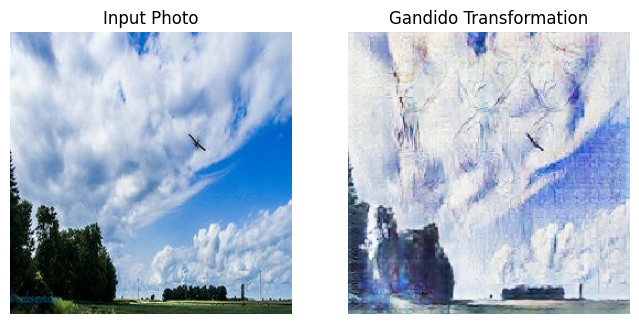

In [50]:
# Display the one of the images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(input_img)
plt.title('Input Photo')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gandido_img)
plt.title('Gandido Transformation')
plt.axis('off')

plt.show()


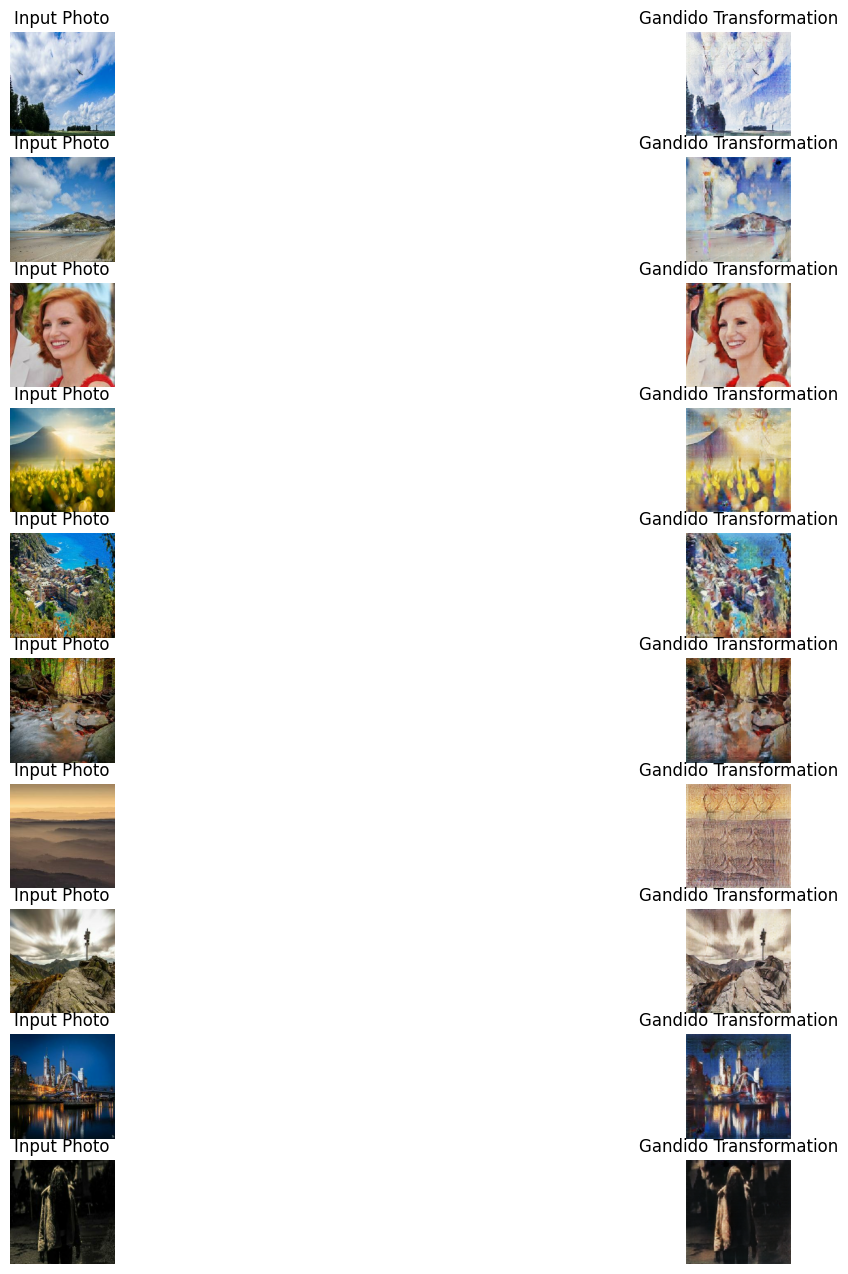

In [51]:
from PIL import Image
import matplotlib.pyplot as plt

# Prepare a figure to display the images
_, ax = plt.subplots(10, 2, figsize=(16, 16))

for i in range(10):  # Replace 10 with the number of images you have
    # Load the images from MyDrive
    input_image_path = f'/content/drive/MyDrive/input_photo_{i}.png'
    gandido_image_path = f'/content/drive/MyDrive/gandido_transformation_{i}.png'

    input_img = Image.open(input_image_path)
    gandido_img = Image.open(gandido_image_path)

    # Convert PIL Image to numpy array for plotting
    input_img_array = np.array(input_img)
    gandido_img_array = np.array(gandido_img)

    # Display the images
    ax[i, 0].imshow(input_img_array)
    ax[i, 1].imshow(gandido_img_array)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Gandido Transformation")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.show()
